In [1]:
#Import the necessary Python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from fbprophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")

In [3]:
#Import the dataset

global_confirmed_cases = pd.read_csv("covid19-data-from-john-hopkins-university/CONVENIENT_global_confirmed_cases.csv")
#global_confirmed_cases

In [4]:
global_confirmed_cases = global_confirmed_cases[1:]
#global_confirmed_cases

In [5]:
#Select Russia's confirmed cases data only for prediction

RUS_confirmed_cases = pd.DataFrame(global_confirmed_cases[["Country/Region","Russia"]])
#RUS_confirmed_cases.head()

In [6]:
#Change the header of Russian confirmed cases data

RUS_confirmed_cases.columns = ['Date','Confirmed cases']
#RUS_confirmed_cases

In [7]:
#Check for missing value(s) in the Russian confirmed cases data

RUS_confirmed_cases.isnull().sum()

Date               0
Confirmed cases    0
dtype: int64

In [8]:
RUS_confirmed_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 1 to 679
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             679 non-null    object 
 1   Confirmed cases  679 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.7+ KB


In [9]:
RUS_confirmed_cases['Date']= pd.to_datetime(RUS_confirmed_cases['Date']) 

In [10]:
RUS_confirmed_cases = RUS_confirmed_cases.set_index(['Date'])

In [11]:
def create_time_features(RUS_confirmed_cases):
    """
    Creates time series features from datetime index
    """
    RUS_confirmed_cases['date'] = RUS_confirmed_cases.index
    RUS_confirmed_cases['hour'] = RUS_confirmed_cases['date'].dt.hour
    RUS_confirmed_cases['dayofweek'] = RUS_confirmed_cases['date'].dt.dayofweek
    RUS_confirmed_cases['quarter'] = RUS_confirmed_cases['date'].dt.quarter
    RUS_confirmed_cases['month'] = RUS_confirmed_cases['date'].dt.month
    RUS_confirmed_cases['year'] = RUS_confirmed_cases['date'].dt.year
    RUS_confirmed_cases['dayofyear'] = RUS_confirmed_cases['date'].dt.dayofyear
    RUS_confirmed_cases['dayofmonth'] = RUS_confirmed_cases['date'].dt.day
    RUS_confirmed_cases['weekofyear'] = RUS_confirmed_cases['date'].dt.weekofyear
    
    X = RUS_confirmed_cases[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [12]:
create_time_features(RUS_confirmed_cases).head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2020-01-23,0,3,1,1,2020,23,23,4
2020-01-24,0,4,1,1,2020,24,24,4
2020-01-25,0,5,1,1,2020,25,25,4
2020-01-26,0,6,1,1,2020,26,26,4
2020-01-27,0,0,1,1,2020,27,27,5


In [13]:
RUS_confirmed_cases.head()

,Confirmed cases,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,
2020-01-23,0.0,2020-01-23,0,3,1,1,2020,23,23,4
2020-01-24,0.0,2020-01-24,0,4,1,1,2020,24,24,4
2020-01-25,0.0,2020-01-25,0,5,1,1,2020,25,25,4
2020-01-26,0.0,2020-01-26,0,6,1,1,2020,26,26,4
2020-01-27,0.0,2020-01-27,0,0,1,1,2020,27,27,5


In [14]:
RUS_confirmed_cases.drop("date", axis=1, inplace=True)
RUS_confirmed_cases.drop("hour", axis=1, inplace=True)
RUS_confirmed_cases.drop("dayofweek", axis=1, inplace=True)
RUS_confirmed_cases.drop("quarter", axis=1, inplace=True)
RUS_confirmed_cases.drop("dayofyear", axis=1, inplace=True)
RUS_confirmed_cases.drop("weekofyear", axis=1, inplace=True)

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df

In [16]:
RUS_confirmed_cases = FunLabelEncoder(RUS_confirmed_cases)
RUS_confirmed_cases.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 679 entries, 2020-01-23 to 2021-12-01
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Confirmed cases  679 non-null    float64
 1   month            679 non-null    int64  
 2   year             679 non-null    int64  
 3   dayofmonth       679 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 26.5 KB


In [17]:
RUS_confirmed_cases

,Confirmed cases,month,year,dayofmonth
Date,,,,
2020-01-23,0.0,1,2020,23
2020-01-24,0.0,1,2020,24
2020-01-25,0.0,1,2020,25
2020-01-26,0.0,1,2020,26
2020-01-27,0.0,1,2020,27
...,...,...,...,...
2021-11-27,33119.0,11,2021,27
2021-11-28,32786.0,11,2021,28
2021-11-29,33170.0,11,2021,29


In [18]:
X = RUS_confirmed_cases[['month', 'year','dayofmonth']]
Y = RUS_confirmed_cases[['Confirmed cases']]

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)

In [20]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()
LR.fit(X_train,Y_train)

LinearRegression()

In [21]:
LR.score(X_test,Y_test)

0.6554306021751815

In [22]:
X_test.shape

(204, 3)

In [23]:
LR_prediction = LR.predict(X_test)
LR_prediction = pd.DataFrame(LR_prediction)
LR_prediction.columns = ["Confirmed Cases_LR.prediction"]
LR_prediction


,Confirmed Cases_LR.prediction
0,16026.863255
1,17889.091759
2,29486.533085
3,14312.318237
4,23161.430147
...,...
199,5288.113711
200,8085.670956
201,13721.584295
202,11514.760992


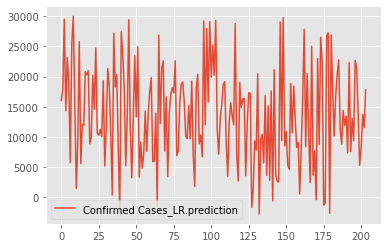

In [24]:
LR_prediction.plot()
plt.show()

In [25]:
LR.predict(X_test)

array([[16026.86325532],
       [17889.09175915],
       [29486.5330855 ],
       [14312.31823684],
       [23161.43014726],
       [18895.46702665],
       [ 5731.16416718],
       [25368.25345024],
       [29978.81137   ],
       [15731.49628462],
       [ 1465.20104657],
       [ 9258.70986103],
       [25762.07607784],
       [ 5583.48068183],
       [12078.08580391],
       [11930.40231856],
       [20785.10466043],
       [20292.82637593],
       [20954.60684428],
       [ 8845.90708076],
       [10018.94598628],
       [20194.37071903],
       [14580.27607759],
       [24728.29168038],
       [10609.67992768],
       [10265.08512853],
       [11268.62185021],
       [ 9997.12728778],
       [19308.26980692],
       [ 5189.65805422],
       [11733.49100476],
       [21348.42947188],
       [18452.4165706 ],
       [10806.59124149],
       [  382.18882066],
       [27181.25412561],
       [18255.50525679],
       [20314.64507442],
       [ 8107.489654  ],
       [-2603.85076024],


In [26]:
import numpy as np
from sklearn.model_selection import cross_val_score
reg_cv=LinearRegression()
cv_scores=cross_val_score(reg_cv,X,Y,cv=6)
np.mean(cv_scores)

-1.8652700475508397

In [27]:
Y_pred = LR.predict(X_test)
print("Coefficients: \n", LR.coef_)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

Coefficients: 
 [[ 2108.36764608 11400.53001255    49.22782845]]
Coefficient of determination: 0.66


In [28]:
from sklearn.ensemble import RandomForestClassifier
tree_model= RandomForestClassifier(n_estimators=100, max_depth=200,
                        random_state=1)
tree_model.fit(X_train,Y_train)
RF_prediction = tree_model.predict(X_test)

<ipython-input-28-dbff8466b610>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_model.fit(X_train,Y_train)


In [29]:
tree_model.fit(X_train,Y_train)
RF_prediction = tree_model.predict(X_test)
print("Coefficient of determination: %.2f" % r2_score(Y_test, RF_prediction))

<ipython-input-29-fcd2b738b854>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tree_model.fit(X_train,Y_train)


Coefficient of determination: 0.95


In [30]:
RF_prediction = pd.DataFrame(RF_prediction)
RF_prediction.columns = ["Confirmed Cases_RF_prediction"]

In [31]:
RF_prediction.head()

,Confirmed Cases_RF_prediction
0,15843.0
1,22441.0
2,36155.0
3,7764.0
4,20312.0


In [32]:
RF_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 1 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Confirmed Cases_RF_prediction  204 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


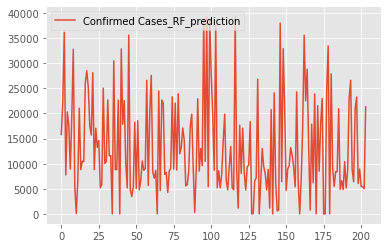

In [33]:
RF_prediction.plot()
plt.show()